In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

## 1. Loading files

In [2]:
clean_nba = pd.read_csv("/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/clean_nba.csv")
test_clean_nba = pd.read_csv("/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/test_clean_nba.csv")

Dropping players name and the team since it wont be important for predicting a position.

In [3]:
position_model = clean_nba.drop(columns=["player_new","Tm"])
test_position_model = test_clean_nba.drop(columns=["player_new","Tm"])

## 2. Dropping columns based on correlation matrix

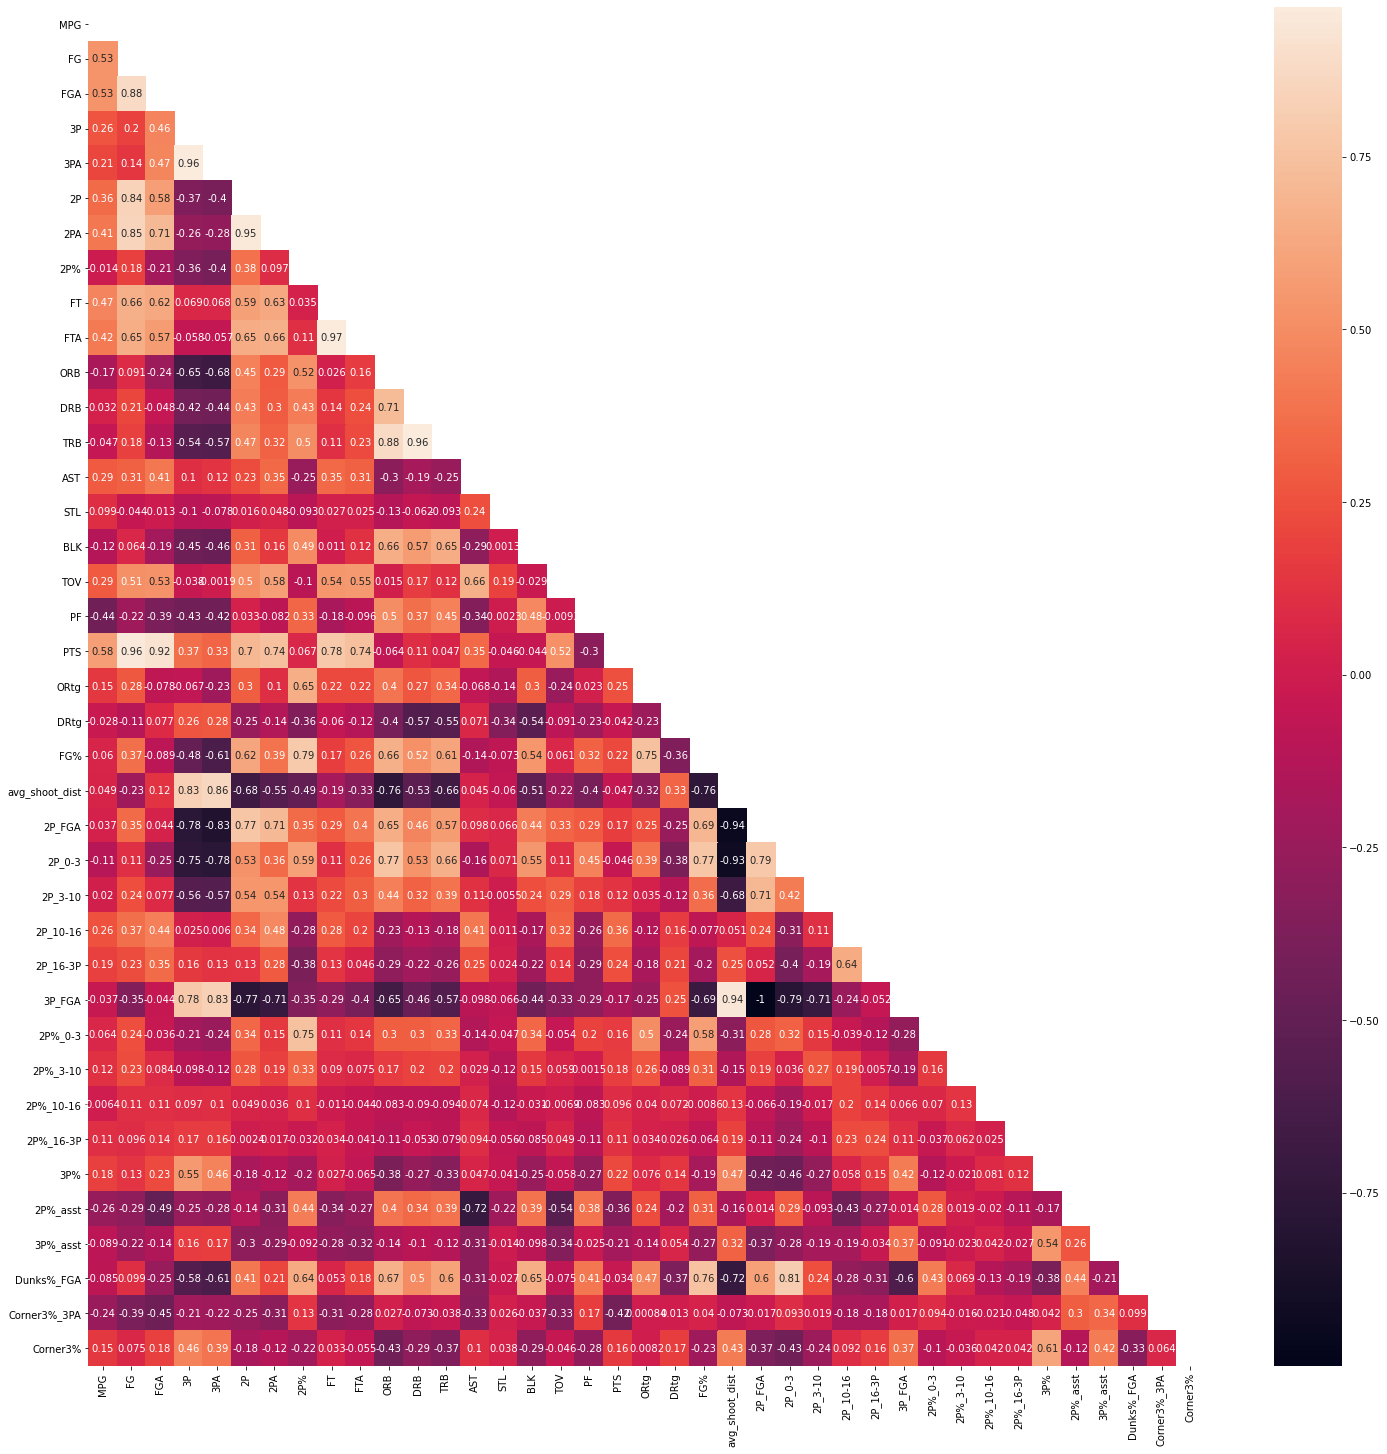

In [4]:
correlations_matrix = position_model.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

Drop columns with high collinearity

In [5]:
position_model = position_model.drop(columns=["FG","FGA", "3P","3PA","2P", "TRB","3P_FGA", "avg_shoot_dist"
                                             ,"2P_FGA","FG%", "2P_FGA","FT","2P%", "PTS","Dunks%_FGA","2P_0-3"])
test_position_model = test_position_model.drop(columns=["FG","FGA", "3P","3PA","2P", "TRB","3P_FGA", "avg_shoot_dist"
                                             ,"2P_FGA","FG%", "2P_FGA","FT","2P%", "PTS","Dunks%_FGA","2P_0-3"])

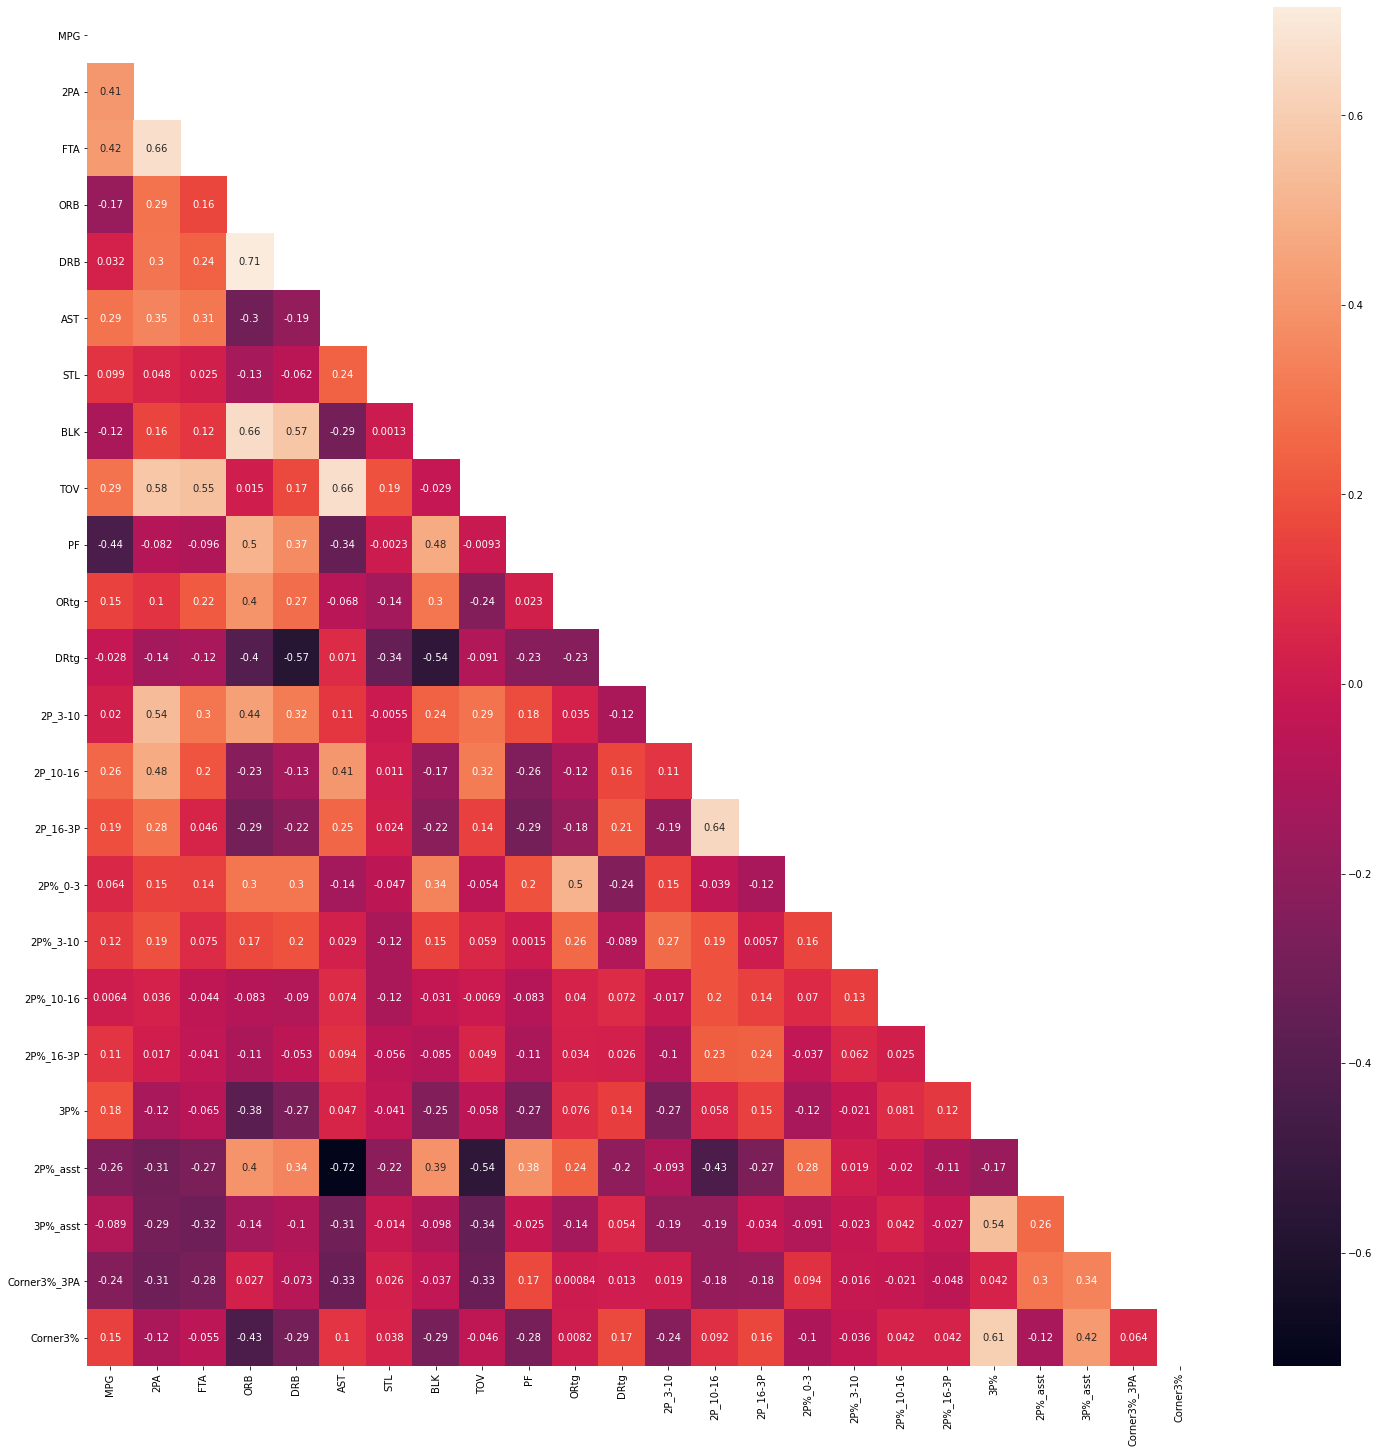

In [6]:
correlations_matrix = position_model.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(25, 25))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [7]:
position_model_1 = position_model.drop(columns=["MPG","PF","2P_16-3P","2P_10-16","2P%_10-16", 
                                                "2P%_3-10", "2P%_16-3P", "Corner3%","DRtg","ORtg"])
test_position_model_1 = test_position_model.drop(columns=["MPG","PF","2P_16-3P","2P_10-16","2P%_10-16", 
                                                "2P%_3-10", "2P%_16-3P", "Corner3%","DRtg","ORtg"])

In [8]:
position_model_1.head()

,Pos,2PA,FTA,ORB,DRB,AST,STL,BLK,TOV,2P_3-10,2P%_0-3,3P%,2P%_asst,3P%_asst,Corner3%_3PA
0,C,13.7,5.8,6.0,10.9,4.2,1.5,1.9,2.7,0.397,0.743,0.333,0.670,1.000,0.333
1,PF,15.7,7.7,3.6,11.3,7.4,1.7,1.9,4.1,0.301,0.726,0.143,0.715,0.500,0.571
2,C,17.3,5.2,2.8,7.9,3.5,1.0,2.4,2.0,0.129,0.719,0.389,0.567,0.951,0.185
3,SG,10.4,2.9,0.7,5.9,7.0,1.3,0.6,4.2,0.173,0.523,0.346,0.192,0.913,0.188
4,SG,7.2,2.9,0.5,5.0,3.4,0.7,0.1,2.1,0.179,0.711,0.404,0.600,0.982,0.255


## 3. Save dataframes after dropping columns

In [9]:
position_model_1.to_csv(r'/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/position_model_1.csv', index = False)
position_model.to_csv(r'/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/position_model.csv', index = False)

test_position_model_1.to_csv(r'/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/test_position_model_1.csv', index = False)
test_position_model.to_csv(r'/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/test_position_model.csv', index = False)

## 4. Training/Test Split

In [10]:
X = position_model_1.drop('Pos', axis=1)
y = position_model_1[['Pos']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Manually encode the labels to make it more meaningful for the confusion matrix later
label_encoder_dict = dict([
    ("C",0),
    ("PG",1),
    ("SG",2),
    ("SF",3),
    ("PF",4)
])

y_train = y_train.Pos.map(label_encoder_dict).values
y_test = y_test.Pos.map(label_encoder_dict).values

print('X_train:',X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (360, 14)
y_train: (360,)
X_test: (121, 14)
y_test: (121,)


In [11]:
position_model_1.columns

Index(['Pos', '2PA', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV',
       '2P_3-10', '2P%_0-3', '3P%', '2P%_asst', '3P%_asst', 'Corner3%_3PA'],
      dtype='object')

## 5. Feature importance

In [12]:
def feature_importance(position_data, league_data):
    """
    takes reduced data,
    performs Principal Component Analysis,
    returns feature importance dataframe
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(position_data)

    pca = PCA(n_components=2)
    PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

    features = pd.DataFrame(zip(position_data.columns, pca.components_[0], np.mean(position_data), np.mean(league_data)),
        columns=['Feature', 'Importance', 'Position Average', 'League Average']).sort_values('Importance', ascending=False).head(10)

    return features

In [13]:
list_pos = ["PG","SG","SF","PF","C"]

for i in list_pos:
    mask = (position_model_1['Pos'] == i)
    position_data = position_model_1[mask].drop(['Pos'], axis=1)
    league_data = position_model_1.drop(['Pos'], axis=1)
    print("Position is ", i)
    print(feature_importance(position_data, league_data).reset_index().drop('index', axis=1))

Position is  PG
   Feature  Importance  Position Average  League Average
0      TOV    0.416064          3.562651        2.631393
1      FTA    0.382975          4.645783        4.120374
2      AST    0.348672          8.432530        4.433888
3      2PA    0.317167         11.691566       10.008108
4      DRB    0.193584          5.006024        6.816008
5  2P%_0-3    0.134896          0.621723        0.651915
6  2P_3-10    0.094228          0.164795        0.162189
7      BLK   -0.021417          0.448193        1.012474
8      STL   -0.028357          1.772289        1.507484
9      ORB   -0.037605          1.112048        2.089605
Position is  SG
   Feature  Importance  Position Average  League Average
0      TOV    0.401536          2.538889        2.631393
1      AST    0.375387          4.452778        4.433888
2      2PA    0.357980          9.227778       10.008108
3      FTA    0.303720          3.744444        4.120374
4  2P_3-10    0.237468          0.141370        0.162189

## 6. Baseline Predictor

In [14]:
pipeline = Pipeline([('standarize', StandardScaler()),
                     ('pca', PCA()),
                     ('clf', DecisionTreeClassifier(class_weight='balanced'))])

param_grid = {"pca__n_components":[5,10,15,18],
              "clf__max_depth":[5,10,15]}

cv = StratifiedKFold(5, shuffle=True)

dt_grid_search = GridSearchCV(pipeline, 
                              param_grid, 
                              verbose=0, 
                              scoring='accuracy', 
                              cv=cv, 
                              n_jobs=-1)

dt_grid_search.fit(X_train, y_train);

baseline_score = dt_grid_search.score(X_test, y_test)
print("Baseline accuracy score is", baseline_score)

Baseline accuracy score is 0.5289256198347108


In [15]:
dt_grid_search.best_estimator_

Pipeline(steps=[('standarize', StandardScaler()), ('pca', PCA(n_components=10)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        max_depth=10))])

In [16]:
def draw_confusion_matrix(y_ground_truth, y_pred):
    """Plots confusion matrix given ground truth and predicted labels"""
    warnings.filterwarnings('ignore')

    cm = confusion_matrix(y_test, y_pred)

    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(9, 7))
    heat_map = sns.heatmap(cm, 
                           annot=True, 
                           fmt="d", 
                           linewidths=1, 
                           ax=ax, 
                           cmap=sns.cubehelix_palette(50),
                           xticklabels=label_encoder_dict.keys(), 
                           yticklabels=label_encoder_dict.keys())

    heat_map.set_xlabel("Predicted Label")
    heat_map.set_ylabel("Ground Truth Label")

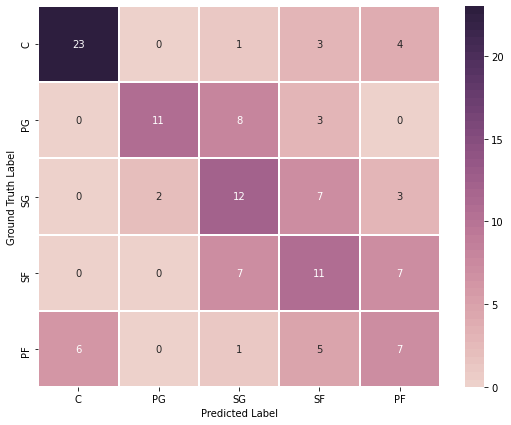

In [17]:
draw_confusion_matrix(y_test, dt_grid_search.predict(X_test))

## 7. Logistic Regression (Multinomial)

VIF

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = []
for idx, col in enumerate(X.columns):
    VIF_i = variance_inflation_factor(X.dropna().values, idx)
    vif_data.append([col, VIF_i])

display(pd.DataFrame(vif_data, columns=['Feature', "VIF"]).sort_values("VIF", ascending=False))

,Feature,VIF
9,2P%_0-3,41.793452
12,3P%_asst,22.218972
11,2P%_asst,20.647347
7,TOV,19.773289
3,DRB,18.600143
0,2PA,17.862137
10,3P%,16.122730
4,AST,10.402623
8,2P_3-10,9.684743
2,ORB,9.195833


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer

pipeline = Pipeline([('standarize', StandardScaler()),
                     ('pca', PCA()),
                     ('clf', LogisticRegression(class_weight='balanced', 
                                                max_iter=10000,
                                                multi_class='multinomial',
                                                solver='saga'))])

param_grid = {"clf__penalty":['l1','l2','none'],
              "clf__C":[.5,.75,1,1.25],
              "pca__n_components":[5,10,15,18]}

scoring = {'Accuracy': make_scorer(accuracy_score), 
           'Balanced Accuracy': make_scorer(balanced_accuracy_score)}

cv = StratifiedKFold(5, shuffle=True)

lr_grid_search = GridSearchCV(pipeline, 
                              param_grid, 
                              verbose=0, 
                              scoring=scoring,
                              cv=cv,
                              n_jobs=-1,
                              refit='Balanced Accuracy')

lr_grid_search.fit(X_train, y_train);

lr_score = lr_grid_search.score(X_test, y_test)

print("Logistic regression accuracy score is %.2f" % lr_score)

Logistic regression accuracy score is 0.59


In [20]:
lr_grid_search.best_estimator_

Pipeline(steps=[('standarize', StandardScaler()), ('pca', PCA(n_components=10)),
                ('clf',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=10000, multi_class='multinomial',
                                    penalty='l1', solver='saga'))])

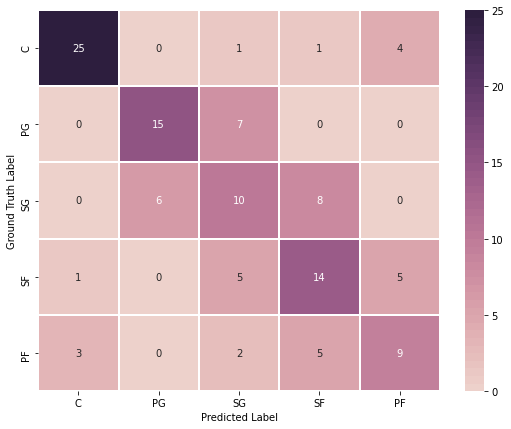

In [21]:
draw_confusion_matrix(y_test, lr_grid_search.predict(X_test))

## 8. Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([('clf', RandomForestClassifier(n_jobs=-1, 
                                                       class_weight='balanced'))])

rf_parameter_grid = {'clf__n_estimators':[500],
                    'clf__max_depth':[8, 12, 16, 18],
                    'clf__min_samples_split':[2, 8, 12, 18]
                    }

rf_gridsearch = GridSearchCV(rf_pipeline, 
                             rf_parameter_grid, 
                             cv=cv, 
                             scoring=scoring, 
                             refit="Balanced Accuracy")

rf_gridsearch.fit(X_train, y_train)

rf_score = rf_gridsearch.score(X_test, y_test)
print("Random forest accuracy score is %.2f" % rf_score)

Random forest accuracy score is 0.58


In [23]:
rf_gridsearch.best_estimator_

Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=18,
                                        min_samples_split=12, n_estimators=500,
                                        n_jobs=-1))])

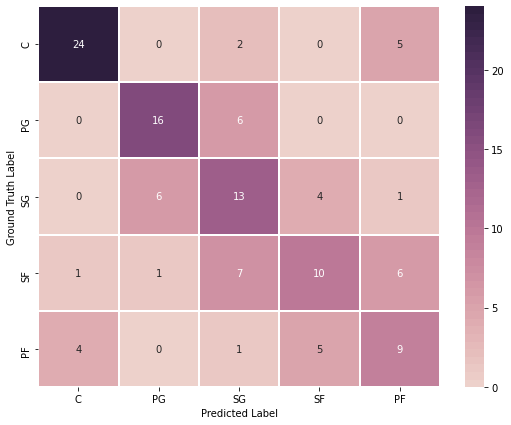

In [24]:
draw_confusion_matrix(y_test, rf_gridsearch.predict(X_test))